In [1]:
# 1. Mount Google Drive and Setup
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [5]:
# 2. Load Data from Google Drive
# Update this path to your dataset location in Google Drive
drive_path = '/content/drive/MyDrive/Colab Notebooks/jena_climate_2009_2016.csv/jena_climate_2009_2016.csv'

try:
    df = pd.read_csv(drive_path)
    print("File loaded successfully from Google Drive!")

    # Display basic info
    print("\nDataset shape:", df.shape)
    print("\nFirst 5 rows:")
    display(df.head())

except Exception as e:
    print(f"Error loading file: {e}")
    print("\nTroubleshooting steps:")
    print("1. Make sure you've mounted Google Drive correctly")
    print("2. Verify the file exists at the specified path")
    print("3. Check the filename is exactly 'jena_climate_2009_2016.csv'")
    print("4. Ensure you have permission to access the file")




File loaded successfully from Google Drive!

Dataset shape: (420551, 15)

First 5 rows:


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [11]:
# 3. Data Preparation
# Extract numerical data (skip Date Time column)
data = df.iloc[:, 1:].values.astype('float32')

def prepare_data(data, split_fraction=0.715):
    train_split = int(split_fraction * data.shape[0])

    # Normalize using training set statistics
    mean = data[:train_split].mean(axis=0)
    std = data[:train_split].std(axis=0)

    data -= mean
    data /= std

    return data, mean, std

data, mean, std = prepare_data(data)

# Parameters for time-series windows
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

def create_dataset(data, sequence_length, delay, sampling_rate, batch_size, shuffle=False):
    dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets=data[delay:][:, 1],  # Temperature is column 1
        sampling_rate=sampling_rate,
        sequence_length=sequence_length,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    return dataset

train_dataset = create_dataset(data[:200000], sequence_length, delay, sampling_rate, batch_size, shuffle=True)
val_dataset = create_dataset(data[200000:300000], sequence_length, delay, sampling_rate, batch_size)
test_dataset = create_dataset(data[300000:], sequence_length, delay, sampling_rate, batch_size)

print(f"\nTraining samples: {len(train_dataset)*batch_size}")
print(f"Validation samples: {len(val_dataset)*batch_size}")
print(f"Test samples: {len(test_dataset)*batch_size}")




Training samples: 198656
Validation samples: 98560
Test samples: 119040


In [13]:
# 4. Model Training Function
def train_and_evaluate_model(model, train_data, val_data, test_data, epochs=10, model_name="Model"):
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    print(f"\nTraining {model_name}...")
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        verbose=1
    )

    plt.figure(figsize=(10, 5))
    plt.plot(history.history["mae"], label="Training MAE")
    plt.plot(history.history["val_mae"], label="Validation MAE")
    plt.title(f"{model_name} - Training History")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

    print("\nTest evaluation:")
    test_results = model.evaluate(test_data, verbose=0)
    print(f"Test MAE: {test_results[1]:.4f}")
    print(f"Test MSE: {test_results[0]:.4f}")

    return test_results


Building Baseline GRU Model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 32)                  │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)


Training Baseline GRU...
Epoch 1/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 160s 199ms/step - loss: 0.1794 - mae: 0.3202 - val_loss: 0.1169 - val_mae: 0.2657
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 195s 190ms/step - loss: 0.1268 - mae: 0.2780 - val_loss: 0.1335 - val_mae: 0.2870
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 149s 191ms/step - loss: 0.1175 - mae: 0.2684 - val_loss: 0.1199 - val_mae: 0.2688
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 150s 192ms/step - loss: 0.1084 - mae: 0.2581 - val_loss: 0.1240 - val_mae: 0.2747
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 147s 190ms/step - loss: 0.1004 - mae: 0.2483 - val_loss: 0.1358 - val_mae: 0.2871
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 154s 198ms/step - loss: 0.0930 - mae: 0.2395 - val_loss: 0.1629 - val_mae: 0.3192
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 164s 211ms/step - loss: 0.0850 - mae: 0.2290 - val_loss: 0.1626 - val_mae: 0.3182
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 190s 196ms/step - loss: 0.0780 - mae: 0.2197 - val_loss: 0.1667 - val_mae: 0.323

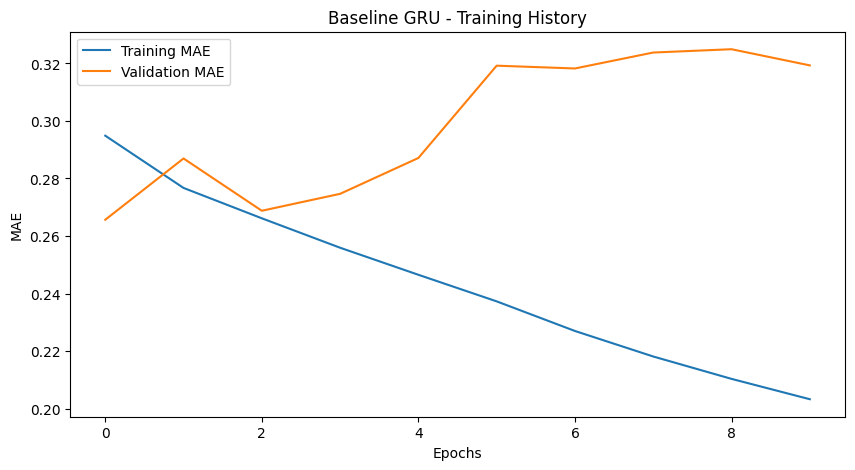


Test evaluation:
Test MAE: 0.3364
Test MSE: 0.1851

Building Stacked GRU Model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 120, 64)             │          15,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,385 (157.75 KB)

 Trainable params: 40,385 (157.75 KB)

 Non-trainable params: 0 (0.00 B)


Training Stacked GRU...
Epoch 1/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 612s 783ms/step - loss: 0.1615 - mae: 0.3109 - val_loss: 0.1254 - val_mae: 0.2747
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 604s 778ms/step - loss: 0.1201 - mae: 0.2713 - val_loss: 0.1423 - val_mae: 0.2953
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 623s 780ms/step - loss: 0.1027 - mae: 0.2513 - val_loss: 0.1467 - val_mae: 0.3010
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 687s 864ms/step - loss: 0.0818 - mae: 0.2246 - val_loss: 0.1794 - val_mae: 0.3325
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 621s 785ms/step - loss: 0.0598 - mae: 0.1927 - val_loss: 0.1815 - val_mae: 0.3344
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 623s 786ms/step - loss: 0.0430 - mae: 0.1627 - val_loss: 0.1737 - val_mae: 0.3265
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 678s 860ms/step - loss: 0.0326 - mae: 0.1409 - val_loss: 0.1920 - val_mae: 0.3441
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 626s 786ms/step - loss: 0.0260 - mae: 0.1256 - val_loss: 0.1883 - val_mae: 0.3397

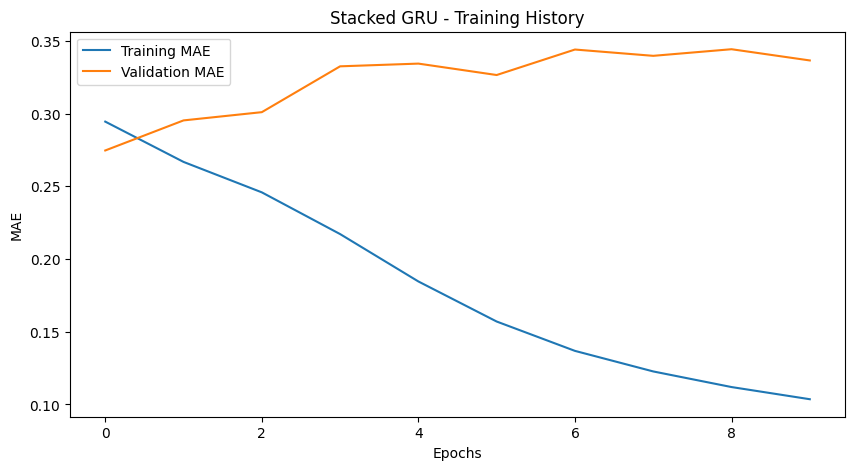


Test evaluation:
Test MAE: 0.3533
Test MSE: 0.2011

Building Stacked LSTM Model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 120, 64)             │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)


Training Stacked LSTM...
Epoch 1/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 547s 701ms/step - loss: 0.1586 - mae: 0.3086 - val_loss: 0.1465 - val_mae: 0.2970
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 612s 765ms/step - loss: 0.0801 - mae: 0.2225 - val_loss: 0.1654 - val_mae: 0.3188
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 573s 703ms/step - loss: 0.0444 - mae: 0.1638 - val_loss: 0.1697 - val_mae: 0.3238
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 564s 706ms/step - loss: 0.0274 - mae: 0.1278 - val_loss: 0.2018 - val_mae: 0.3523
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 588s 758ms/step - loss: 0.0198 - mae: 0.1087 - val_loss: 0.1961 - val_mae: 0.3456
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 628s 767ms/step - loss: 0.0159 - mae: 0.0966 - val_loss: 0.1891 - val_mae: 0.3385
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 550s 708ms/step - loss: 0.0133 - mae: 0.0884 - val_loss: 0.1884 - val_mae: 0.3367
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 600s 773ms/step - loss: 0.0115 - mae: 0.0820 - val_loss: 0.1975 - val_mae: 0.347

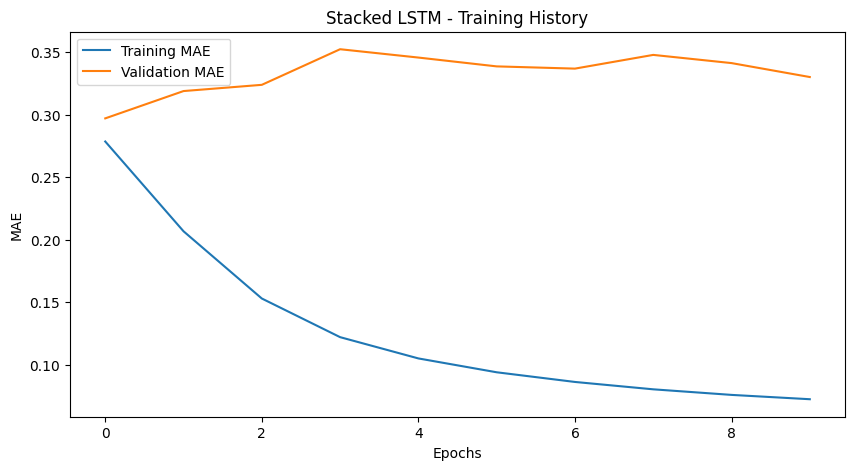


Test evaluation:
Test MAE: 0.3406
Test MSE: 0.1853

Building CNN+RNN Hybrid Model


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 116, 64)             │           4,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 38, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 34, 64)              │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 34, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,073 (293.25 KB)

 Trainable params: 75,073 (293.25 KB)

 Non-trainable params: 0 (0.00 B)


Training CNN+RNN Hybrid...
Epoch 1/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 294s 372ms/step - loss: 0.2076 - mae: 0.3513 - val_loss: 0.1581 - val_mae: 0.3089
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 320s 370ms/step - loss: 0.1043 - mae: 0.2535 - val_loss: 0.1885 - val_mae: 0.3409
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 322s 370ms/step - loss: 0.0676 - mae: 0.2041 - val_loss: 0.2025 - val_mae: 0.3535
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 360s 419ms/step - loss: 0.0449 - mae: 0.1661 - val_loss: 0.1843 - val_mae: 0.3362
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 286s 368ms/step - loss: 0.0321 - mae: 0.1401 - val_loss: 0.2146 - val_mae: 0.3631
Epoch 6/10
507/776 ━━━━━━━━━━━━━━━━━━━━ 1:24 316ms/step - loss: 0.0252 - mae: 0.1243

In [ ]:
# 5. Model Architectures
# Model 1: Baseline GRU
print("\n" + "="*50)
print("Building Baseline GRU Model")
print("="*50)
model1 = keras.Sequential([
    layers.Input(shape=(sequence_length, data.shape[-1])),
    layers.GRU(32),
    layers.Dense(1)
])
model1.summary()
test_results1 = train_and_evaluate_model(model1, train_dataset, val_dataset, test_dataset, model_name="Baseline GRU")

# Model 2: Stacked GRU
print("\n" + "="*50)
print("Building Stacked GRU Model")
print("="*50)
model2 = keras.Sequential([
    layers.Input(shape=(sequence_length, data.shape[-1])),
    layers.GRU(64, return_sequences=True),
    layers.GRU(64),
    layers.Dense(1)
])
model2.summary()
test_results2 = train_and_evaluate_model(model2, train_dataset, val_dataset, test_dataset, model_name="Stacked GRU")

# Model 3: Stacked LSTM
print("\n" + "="*50)
print("Building Stacked LSTM Model")
print("="*50)
model3 = keras.Sequential([
    layers.Input(shape=(sequence_length, data.shape[-1])),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(1)
])
model3.summary()
test_results3 = train_and_evaluate_model(model3, train_dataset, val_dataset, test_dataset, model_name="Stacked LSTM")

# Model 4: CNN + RNN Hybrid
print("\n" + "="*50)
print("Building CNN+RNN Hybrid Model")
print("="*50)
model4 = keras.Sequential([
    layers.Input(shape=(sequence_length, data.shape[-1])),
    layers.Conv1D(64, 5, activation="relu"),
    layers.MaxPooling1D(3),
    layers.Conv1D(64, 5, activation="relu"),
    layers.GRU(64, return_sequences=True),
    layers.GRU(64),
    layers.Dense(1)
])
model4.summary()
test_results4 = train_and_evaluate_model(model4, train_dataset, val_dataset, test_dataset, model_name="CNN+RNN Hybrid")


Model Comparison:


,MSE,MAE
Baseline GRU,0.185081,0.336409
Stacked GRU,0.201086,0.353312
Stacked LSTM,0.185303,0.340599
CNN+RNN Hybrid,0.209663,0.360797


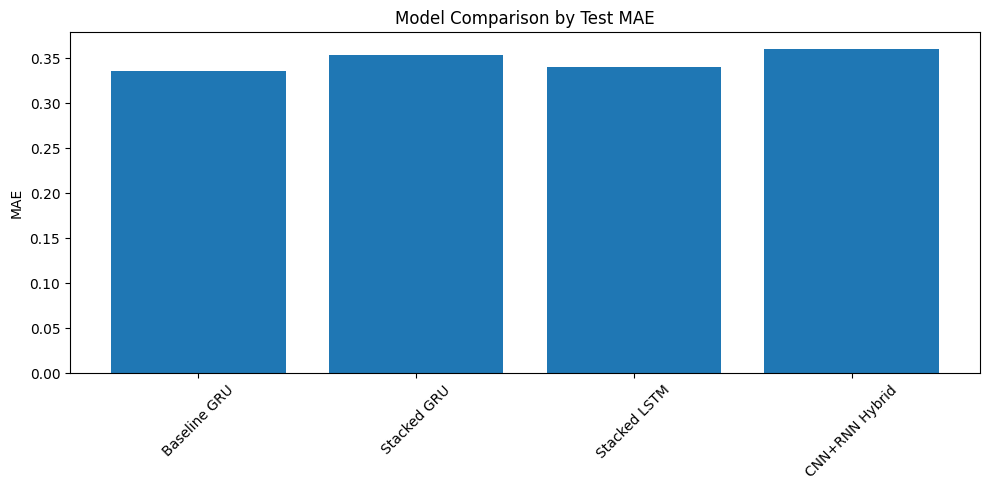

In [15]:
# 6. Results Comparison
results = {
    "Baseline GRU": test_results1,
    "Stacked GRU": test_results2,
    "Stacked LSTM": test_results3,
    "CNN+RNN Hybrid": test_results4
}

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE', 'MAE'])
print("\nModel Comparison:")
display(results_df)

plt.figure(figsize=(10, 5))
plt.bar(results_df.index, results_df['MAE'])
plt.title("Model Comparison by Test MAE")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


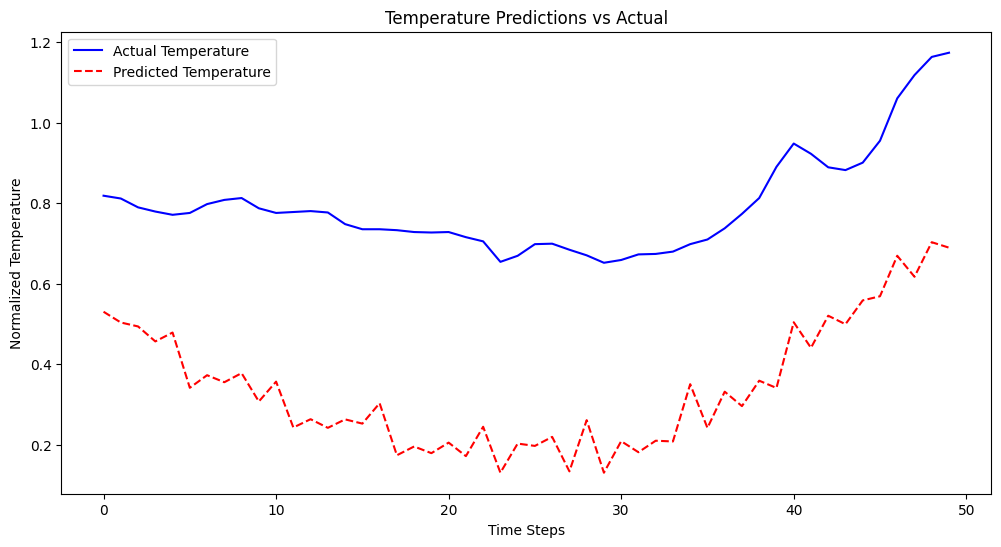

In [16]:
# 8. Example Prediction Visualization
for samples, targets in test_dataset.take(1):
    pass

predictions = model4.predict(samples)

plt.figure(figsize=(12, 6))
plt.plot(targets[:50].numpy(), "b-", label="Actual Temperature")
plt.plot(predictions[:50], "r--", label="Predicted Temperature")
plt.title("Temperature Predictions vs Actual")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Temperature")
plt.legend()
plt.show()